In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Problem 1: Modeling the environment

The dynamics of the car are modeled using a discretization of the position and velocity of the car.
$$
s_i = \langle x(t_i), v(t_i) \rangle \in [-5, 5] \times [-5, 5]
$$

The control input is defined to be $u(t) = \dot{v(t)}$, and this can only be changed every 0.1 seconds.

Each **episode** (a sequence of interactions between the model and the environment) is defined to be a sequence of states $s_0, s_{\delta}, s_{2\delta}, ...$

The Q table is an approximation for the action-value function. This means it approximates the expected return (accumulated rewards) of an interaction when given a state and an action.

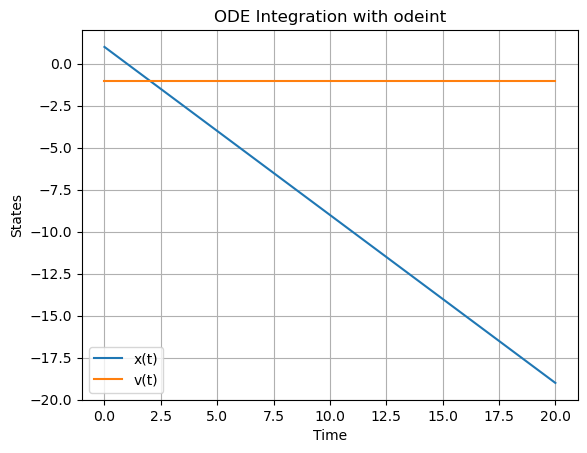

In [2]:
def model(s, t, u):
    # this is changing the state by incrementing the position
    # by the velocity and the velocity by the acceleration
    dsdt = [s[1], u]
    return dsdt

# the state of the system, which is the position and velocity of the car
s0 = [1, -1]
# the control input, which is the acceleration of the car
u_i = 0
delta = 0.1
step = np.linspace(0, 200*delta)
# this function generates each state at each time step
y = odeint(model, s0, step, args=(u_i,))

plt.plot(step, y[:, 0], label='x(t)')
plt.plot(step, y[:, 1], label='v(t)')
plt.title('ODE Integration with odeint')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.grid()
plt.show()

In [3]:
s0 = [0.6, -2]
u = 1
step = np.linspace(0, delta)
y = odeint(model, s0, step, args=(u,))
y[-1]

array([ 0.405, -1.9  ])

# Q Table

The Q table we're expected to make is kind of complicated. It's a 3D array that's indexed using the values of [x, v, u]. Although, this isn't much of a problem.

Since x and v are discretized, we can simply derive a map from x and v to an index in the array. To do this, we can use the points $(-5, 0), (5, 20)$.

$$
y - y_0 = m(x - x_0) \\
\\
y_0 = 0, x_0 = -5, m = \frac{20 - 0}{5 + 5} = 2 \\
\\
y = 2x + 10
$$

For u, the points are not linearly spaced, so we have to create a table of values for u to an index. We could also do this for x and v as well.

In [4]:
X = np.linspace(-5, 5, 21)


line = 2*X + 10

line

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [5]:
U = np.array([-5, -1, -0.1, -0.01, -0.001, -0.0001, 0,
              0.0001, 0.001, 0.01, 0.1, 1, 5])

u_to_index = {u_val: i for i, u_val in enumerate(U)}
u_to_index

{np.float64(-5.0): 0,
 np.float64(-1.0): 1,
 np.float64(-0.1): 2,
 np.float64(-0.01): 3,
 np.float64(-0.001): 4,
 np.float64(-0.0001): 5,
 np.float64(0.0): 6,
 np.float64(0.0001): 7,
 np.float64(0.001): 8,
 np.float64(0.01): 9,
 np.float64(0.1): 10,
 np.float64(1.0): 11,
 np.float64(5.0): 12}

## The purpose of the control law and generating trajectories (task 1.1)

What he's asking us to do is create a function `generate_trajectory` which creates an episode based on an initial state $s_0$. This function is **supposed** to interact with the Agent to retrieve the next action.

In [6]:
trajectory = np.empty((10,), dtype=object)
trajectory

array([None, None, None, None, None, None, None, None, None, None],
      dtype=object)

In [7]:
trajectory[0] = ((1, 2), 2, 3)
trajectory

array([((1, 2), 2, 3), None, None, None, None, None, None, None, None,
       None], dtype=object)

## Modeling the reward signal

What I'm thinking of doing is going through a sequence of steps which accumulate the reward returned to the agent. Maybe, the negative rewards should scale based on how far away from (0, 0) the car is? Also, we can use the fact we already know the next state when computing the reward, which gives us better information to determine if the action was "good" or "bad".

We want to punish the agent if it is causing the car to move when it's stationary, or when if it's preventing the car from being stationary.
- If x != 0
- If x = 0 and (v != 0 or u != 0)
- If v != 0 and (sign(v) = sign(u))
- If x != 0 and v = 0
- If x !- 0 and (sign(x) = sign(v))

We want to reward the model if the state of the car is progressing to be stationary or if it is stationary.
- If x = 0 and v = 0
- If v != 0 and (sign(u) != sign(v))
- If x != 0 and (sign(x) != sign(v))

Another thing we want to do is discourage large velocity and acceleration when the position is near 0.

# Writing the Q learning algorithm

The idea behind the Q learning algorithm is we continuously update the return value (which each entry in Q represents).

For problem 1, we are probably expected to make the car start off in a random number of states. It will terminate if the state reaches (0, 0), the position reaches or exceeds -5 or 5, or if we reach the maximum number of episodes.

In [16]:
X = np.linspace(-5, 5, 21)

random_idx = np.random.default_rng().choice(X.size)

s_x_0 = X[random_idx]
s_x_0

np.float64(-5.0)